In [83]:
import os
import io
import operator
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.model_selection import LeaveOneOut, KFold
import matplotlib.pyplot as plt
import sklearn.metrics as skm

%matplotlib inline



CHARGED="charged/"
NON_CHARGED="non_charged/"

# Functions to extract the data and put it as a DataFrame

In [84]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def sorted_dictionary(folder):
    len_file={}
    for filename in os.listdir(folder):
        len_file[filename]=file_len(folder+filename)
    sorted_len_file=sorted(len_file.items(), key=lambda x: -x[1])
    return sorted_len_file

In [85]:
def create_list(fname):
    l=[]
    fname=fname
    file=open(fname,'r')
    file=file.readlines()
    for e in file:
        e=e.replace(' ','')
        e=e[:-1].split(',')
        ideology=float(e[0])
        count=int(e[1])
        freq1=float(e[2])
        freq2=float(e[3])
        duration=float(e[4])
        F11=float(e[5])
        F12=float(e[6])
        F13=float(e[7])
        F21=float(e[8])
        F22=float(e[9])
        F23=float(e[10])
        l.append([ideology,count,freq1,freq2,duration,F11,F12,F13,F21,F22,F23])
    return l       

In [86]:
def create_dataset(folder,file):
    l_df=create_list(folder+file)
    col=['Ideology','Count','Freq1','Freq2','Duration','F11','F12','F13','F21','F22','F23']
    df=pd.DataFrame(l_df)
    df.columns=col
    y=df['Ideology']
    x=df.drop('Ideology',axis=1)
    x=df.drop('Count',axis=1)
    y[y>0.5]=1
    y[y<0.5]=0
    return x,y

# Functions to extract the score for each regressor and find the optimal regularization

In [87]:
def score_regressor(regressor,x,y,lambdas,split_size=5):
    if split_size>len(y):
        if len(y)>1:
            split_size=len(y)
        else:
            return -1
    scores=[]
    kf=KFold(n_splits=split_size)
    for train_index, test_index in kf.split(x):
        history=[]
        X_train, X_test = x.T[train_index].T, x.T[test_index].T
        y_train, y_test = y.T[train_index].T, y.T[test_index].T
        for i in range(len(lambdas)):
            l=lambdas[i]
            if regressor=='Lasso':
                lr=Lasso(alpha=l,normalize=True)
            elif regressor=='Ridge':
                lr=Ridge(alpha=l,normalize=True)
            else:
                lr=ElasticNet(alpha=l,normalize=True)
            lr.fit(X_train,y_train)
            score=lr.score(X_test,y_test)
            history.append(score)
        scores.append(history)
    s_reg=np.zeros(len(lambdas))
    for e in scores:
        for i in range(len(e)):
            s_reg[i]+=e[i]/len(scores)
    return s_reg

def score_lasso_ridge_elastic(x,y,lambdas,split_size=5):
    s_lasso=score_regressor('Lasso',x,y,lambdas,split_size)
    s_ridge=score_regressor('Ridge',x,y,lambdas,split_size)
    s_elastic=score_regressor('Elastic',x,y,lambdas,split_size)
    return s_lasso,s_ridge,s_elastic

In [88]:
def optimal_lambda(s_lasso,s_ridge,s_elastic):
    lambda_lasso=lambdas[list(s_lasso).index(max(s_lasso))]
    lambda_ridge=lambdas[list(s_ridge).index(max(s_ridge))]
    lambda_elastic=lambdas[list(s_elastic).index(max(s_elastic))]
    #print('The lambdas we will choose are \n lambda_lasso='+str(lambda_lasso)+'\n lambda_ridge='+str(lambda_ridge)+'\n lambda_elastic='+str(lambda_elastic))
    return lambda_lasso,lambda_ridge,lambda_elastic

# Let's run this on an example

In [89]:
sorted_len_file=sorted_dictionary(CHARGED)

The format of this dictionary is the following:

$$(\text{file name},\text{instances in that file})$$

Here are the 5 top entries:

In [90]:
sorted_len_file[:5]

[('MR_ER_2.0.txt', 105),
 ('MR_IH_1.0.txt', 105),
 ('HONOR_ER_2.0.txt', 99),
 ('HONOR_AA_1.0.txt', 99),
 ('FEDERAL_EH_1.0.txt', 85)]

In [91]:
x,y=create_dataset(CHARGED,sorted_len_file[0][0])

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Here are the first ten entries of the resulting $X$:

In [92]:
x.head(10)

,Ideology,Freq1,Freq2,Duration,F11,F12,F13,F21,F22,F23
0,0.000000,464.500000,1778.000000,0.060000,468.000000,465.500000,506.500000,1766.500000,1830.000000,1976.000000
1,0.287978,575.293051,1714.894260,0.058124,608.833837,573.622356,587.706949,1763.235650,1708.492447,1702.299094
2,0.267543,590.563660,1630.338196,0.054023,623.214854,586.973475,585.263926,1689.190981,1615.009284,1629.224138
3,1.000000,535.666667,1611.333333,0.047000,547.333333,535.666667,529.333333,1659.666667,1560.000000,1514.333333
4,0.020829,534.166667,1854.666667,0.059667,535.000000,526.333333,507.166667,1858.000000,1765.333333,1838.166667
5,0.436437,476.000000,1685.000000,0.060000,482.500000,481.000000,587.500000,1673.000000,1674.500000,1662.000000
6,0.494919,577.100000,1904.600000,0.050100,582.600000,557.000000,607.200000,1897.100000,1922.300000,1940.000000
7,0.430435,607.714286,1600.142857,0.075714,608.285714,636.285714,632.714286,1616.714286,1583.142857,1565.428571
8,0.072612,555.600000,1747.600000,0.030000,555.600000,585.200000,624.200000,1747.600000,1762.200000,1775.800000
9,0.333333,460.500000,1676.500000,0.030000,460.500000,447.500000,434.500000,1676.500000,1675.000000,1672.000000


and the first ten entries of $Y$:

In [93]:
y.head(10)

0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: Ideology, dtype: float64

In [94]:
lambdas=np.arange(1e-3,4e-2,1e-3)
s_lasso,s_ridge,s_elastic=score_lasso_ridge_elastic(x,y,lambdas)

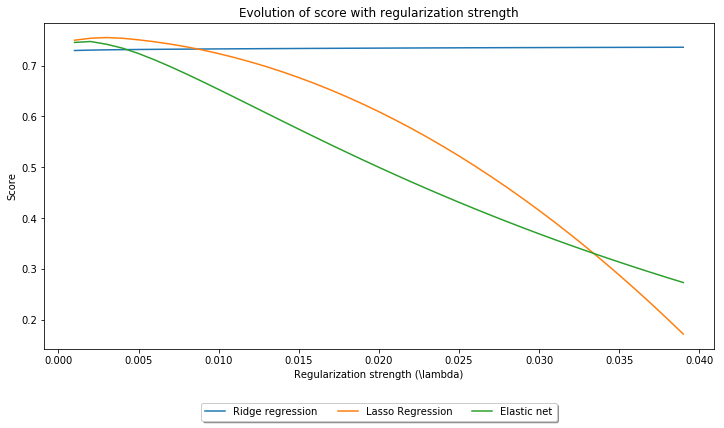

In [95]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.plot(lambdas,s_ridge,label='Ridge regression')
plt.plot(lambdas,s_lasso,label='Lasso Regression')
plt.plot(lambdas,s_elastic,label='Elastic net')
plt.xlabel('Regularization strength (\lambda)')
plt.ylabel('Score')
plt.title('Evolution of score with regularization strength')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [96]:
lambda_lasso,lambda_ridge,lambda_elastic=optimal_lambda(s_lasso,s_ridge,s_elastic)

# Functions to compute AUC and Accuracy

In [97]:
def AUC_regressor(type_of_regressor,x,y,lambda_lasso=lambda_lasso,lambda_ridge=lambda_ridge,lamda_elastic=lambda_elastic,split_size=5):
    if split_size>len(y):
        if len(y)>1:
            split_size=len(y)
        else:
            return -1
    fig = plt.figure(figsize = (12, 6))
    ax = plt.subplot(111)
    kf=KFold(n_splits=split_size)
    for train_index, test_index in kf.split(x):
        history=[]
        X_train, X_test = x.T[train_index].T, x.T[test_index].T
        y_train, y_test = y.T[train_index].T, y.T[test_index].T
        if type_of_regressor=='Ridge':
            lr=Ridge(alpha=lambda_ridge,normalize=True)
        elif type_of_regressor=='Lasso':
            lr=Lasso(alpha=lambda_lasso,normalize=True)
        else:
            lr=ElasticNet(alpha=lambda_elastic,normalize=True)
        lr.fit(X_train,y_train)
        y_predict=lr.predict(X_test)
        y_predict[y_predict>0.5]=1
        y_predict[y_predict<0.5]=0
        y_predict=y_predict.astype(int)
        y_test=y_test.astype(int)
        fpr, tpr, thresholds =skm.roc_curve(y_test,y_predict)
        roc_auc = skm.auc(fpr, tpr)
        print(roc_auc)
        plt.plot(fpr,tpr, label = 'Lasso regression' + ' (AUC = %0.3f)' % roc_auc)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
        ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
                      shadow = True, ncol = 4, prop = {'size':10})

In [98]:
def Accuracy_regressor(type_of_regressor,x,y,lambda_reg,split_size=5):
    if split_size>len(y):
        if len(y)>1:
            split_size=len(y)
        else:
            return -1
        split_size=len(y)
    kf=KFold(n_splits=split_size)
    accuracy=0
    for train_index, test_index in kf.split(x):
        history=[]
        X_train, X_test = x.T[train_index].T, x.T[test_index].T
        y_train, y_test = y.T[train_index].T, y.T[test_index].T
        if type_of_regressor=='Ridge':
            lr=Ridge(alpha=lambda_reg,normalize=True)
        elif type_of_regressor=='Lasso':
            lr=Lasso(alpha=lambda_reg,normalize=True)
        else:
            lr=ElasticNet(alpha=lambda_reg,normalize=True)
        lr.fit(X_train,y_train)
        y_predict=lr.predict(X_test)
        y_predict[y_predict>0.5]=1
        y_predict[y_predict<0.5]=0
        y_predict=list(y_predict)
        y_test=list(y_test)
        acc=0
        for i in range(len(y_test)):
            if y_test[i]==y_predict[i]:
                acc+=1
        accuracy+=acc/len(y_predict)
    return accuracy/split_size

def Accuracy_lasso_ridge_elastic(x,y,lambda_lasso,lambda_ridge,lambda_elastic,split_size=5):
    lasso=Accuracy_regressor('Lasso',x,y,lambda_lasso,split_size)
    ridge=Accuracy_regressor('Ridge',x,y,lambda_ridge,split_size)
    ela=Accuracy_regressor('Elastic',x,y,lambda_elastic,split_size)
    return lasso,ridge,ela

In [114]:
#Find the optimal k for the corss-validation
#acc_lasso=[]
#acc_ridge=[]
#acc_ela=[]
#range_k=range(2,20,1)
#for k in range_k:
#    lasso=Accuracy_regressor('Lasso',x,y,split_size=k)
#    ridge=Accuracy_regressor('Ridge',x,y,split_size=k)
#    ela=Accuracy_regressor('Elastic',x,y,split_size=k)
#    acc_lasso.append(lasso)
#    acc_ridge.append(ridge)
#    acc_ela.append(ela)
#plt.plot(acc_ela)

# Function to get accuracy on all files

Function that returns the accuracy for each regressor for each file in the following lists:

$$\text{acc_lasso},\text{acc_ridge},\text{acc_ela}$$

returns dictionaries for each type of regression:

$$\text{d_lasso},\text{d_ridge},\text{d_ela}$$

The keys are the size of the input, the values are the accuracies for a given input size.

also return $\text{x_axis}$ which contains in the correct order the length of each file, which is useful when we try to plot the figures later

In [100]:
lambdas=np.arange(1e-3,4e-2,1e-3)
def accuracy_on_all_files(folder):
    sorted_len_file=sorted_dictionary(folder)
    acc_lasso=[]
    acc_ridge=[]
    acc_ela=[]
    x_axis=[]
    k=0
    d_lasso={}
    d_ridge={}
    d_ela={}
    for file in sorted_len_file:
        d_lasso[file_len(folder+file[0])]=[]
        d_ridge[file_len(folder+file[0])]=[]
        d_ela[file_len(folder+file[0])]=[]
    for file in sorted_len_file:
        if k%10==0:
            print(str(100*k/len(sorted_len_file))+"% complete")
        n=file_len(folder+file[0])
        if n<2:
            print(file[0]+"was too small")
        else:
            x_axis.append(file_len(folder+file[0]))
            x,y=create_dataset(folder,file[0])
            s_lasso, s_ridge, s_elastic=score_lasso_ridge_elastic(x,y,lambdas)
            lambda_lasso,lambda_ridge,lambda_elastic=optimal_lambda(s_lasso, s_ridge, s_elastic)
            lasso,ridge,ela=Accuracy_lasso_ridge_elastic(x,y,lambda_lasso,lambda_ridge,lambda_elastic)
            acc_lasso.append(lasso)
            acc_ridge.append(ridge)
            acc_ela.append(ela)
            d_lasso[n].append(lasso)
            d_ridge[n].append(ridge)
            d_ela[n].append(ela)
            k+=1
    return acc_lasso,acc_ridge,acc_ela,d_lasso,d_ridge,d_ela,x_axis

# Functions to average the accuracy for each key in the dictionaries and functions to plot the results obtained from accuracy_on_all_files

In [138]:
def average_dictionaries(d_lasso,d_ridge,d_ela):
    for key in d_lasso:
        try:
            d_lasso[key]=sum(d_lasso[key])/len(d_lasso[key])
        except ZeroDivisionError:
            d_lasso[key]=0
    for key in d_ridge:
        try:
            d_ridge[key]=sum(d_ridge[key])/len(d_ridge[key])
        except ZeroDivisionError:
            d_ridge[key]=0
    for key in d_ela:
        try:
            d_ela[key]=sum(d_ela[key])/len(d_ela[key])
        except ZeroDivisionError:
            d_ela[key]=0
def plot_lists_from_dictionaries(d_lasso,d_ridge,d_ela,x_axis):
    d_lasso_list=[]
    d_ridge_list=[]
    d_ela_list=[]
    for p in x_axis:
        d_lasso_list.append(d_lasso[p])
        d_ridge_list.append(d_ridge[p])
        d_ela_list.append(d_ela[p])
    return d_lasso_list,d_ridge_list,d_ela_list

def plot_regressor_accuracy(regressor,x_axis,acc_reg,d_reg_list):
    fig = plt.figure(figsize = (12, 6))
    ax = plt.subplot(111)
    plt.scatter(x_axis,acc_reg,label='Accuracy of '+regressor+' regression')
    plt.plot(x_axis,d_reg_list,color='r',label='Average performance')
    plt.xlabel('Size of file')
    plt.ylabel('Accuracy')
    plt.title('Evolution of accuracy with the size of the file')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
    ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
                  shadow = True, ncol = 4, prop = {'size':10})

# Let's now apply those functions to evaluate how we perform on ideologically charged words

In [118]:
acc_lasso_charged,acc_ridge_charged,acc_ela_charged,d_lasso_charged,d_ridge_charged,d_ela_charged,x_axis_charged=accuracy_on_all_files(CHARGED)
average_dictionaries(d_lasso_charged,d_ridge_charged,d_ela_charged)
d_lasso_list_charged,d_ridge_list_charged,d_ela_list_charged=plot_lists_from_dictionaries(d_lasso_charged,d_ridge_charged,d_ela_charged,x_axis_charged)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0% complete
6.944444444444445% complete
13.88888888888889% complete
20.833333333333332% complete
27.77777777777778% complete
34.72222222222222% complete
41.666666666666664% complete
48.611111111111114% complete
55.55555555555556% complete
62.5% complete
69.44444444444444% complete
76.38888888888889% complete
POLICY_AH_1.0.txtwas too small
76.38888888888889% complete
GOVERNMENT_AH_6.0.txtwas too small
76.38888888888889% complete
POLICY_AA_4.0.txtwas too small
76.38888888888889% complete
KENNEDY_AH_5.0.txtwas too small
76.38888888888889% complete
PEOPLE_IY_2.0.txtwas too small
76.38888888888889% complete
POLICY_IY_2.0.txtwas too small
76.38888888888889% complete
AUTHORITY_IY_2.0.txtwas too small
76.38888888888889% complete
HONOR_ER_3.0.txtwas too small
76.38888888888889% complete
LEGISLATIVE_EH_5.0.txtwas too small
76.38888888888889% complete
LEGISLATURE_AH_1.0.txtwas too small
76.38888888888889% complete
GOVERNMENT_ER_5.0.txtwas too small
76.38888888888889% complete
KENNEDY_IY_6.0.txt

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


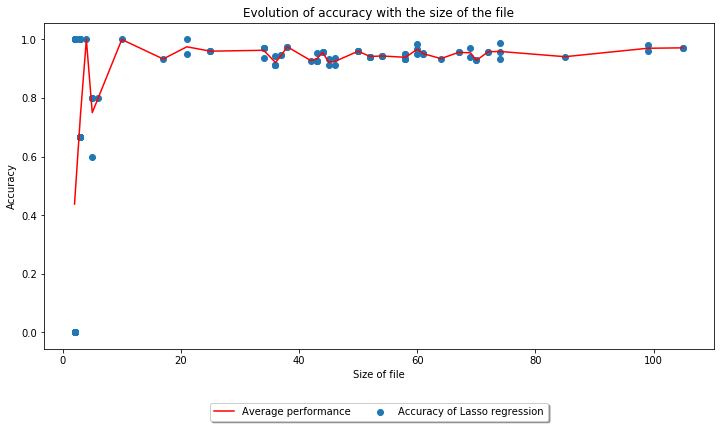

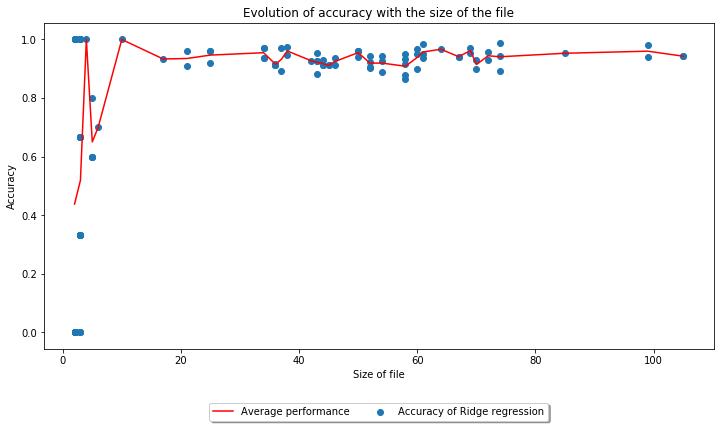

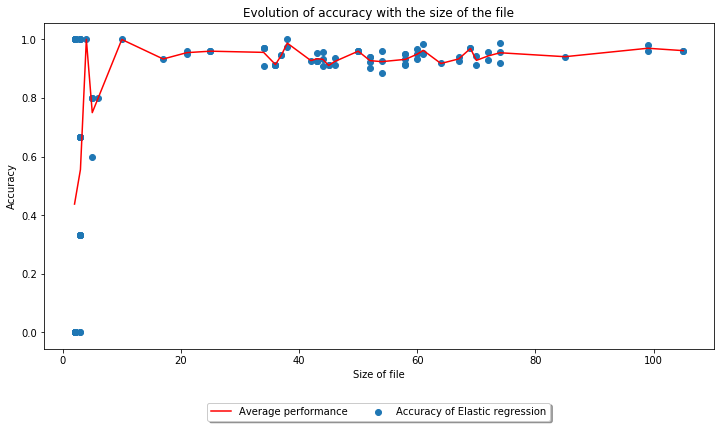

In [139]:
plot_regressor_accuracy('Lasso',x_axis_charged,acc_lasso_charged,d_lasso_list_charged)
plot_regressor_accuracy('Ridge',x_axis_charged,acc_ridge_charged,d_ridge_list_charged)
plot_regressor_accuracy('Elastic',x_axis_charged,acc_ela_charged,d_ela_list_charged)

# And now let's plot the results for non charged words

In [122]:
acc_lasso,acc_ridge,acc_ela,d_lasso,d_ridge,d_ela,x_axis=accuracy_on_all_files(NON_CHARGED)
average_dictionaries(d_lasso,d_ridge,d_ela)
d_lasso_list,d_ridge_list,d_ela_list=plot_lists_from_dictionaries(d_lasso,d_ridge,d_ela,x_axis)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0% complete
7.633587786259542% complete
15.267175572519085% complete
22.900763358778626% complete
30.53435114503817% complete
38.16793893129771% complete
45.80152671755725% complete
53.43511450381679% complete
61.06870229007634% complete
68.70229007633588% complete
76.33587786259542% complete
CERTAINLY_AH_5.0.txtwas too small
CERTAINLY_ER_3.0.txtwas too small
CERTAINLY_ER_4.0.txtwas too small
ABSOLUTELY_UW_6.0.txtwas too small
CERTAINLY_AH_4.0.txtwas too small
EXACTLY_IH_5.0.txtwas too small
PARTICULAR_ER_2.0.txtwas too small
DIFFERENT_IH_3.0.txtwas too small
CERTAINLY_IY_5.0.txtwas too small
ABSOLUTELY_IY_2.0.txtwas too small
DIFFERENT_ER_4.0.txtwas too small
EXACTLY_IY_5.0.txtwas too small
ABSOLUTELY_AE_4.0.txtwas too small
ABSOLUTELY_UW_1.0.txtwas too small
UNDER_AH_5.0.txtwas too small
EXACTLY_AE_4.0.txtwas too small
SITUATION_EY_1.0.txtwas too small
PARTICULAR_AH_1.0.txtwas too small
ABSOLUTELY_IY_6.0.txtwas too small
ABSOLUTELY_IY_7.0.txtwas too small
OTHER_ER_6.0.txtwas too sm

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


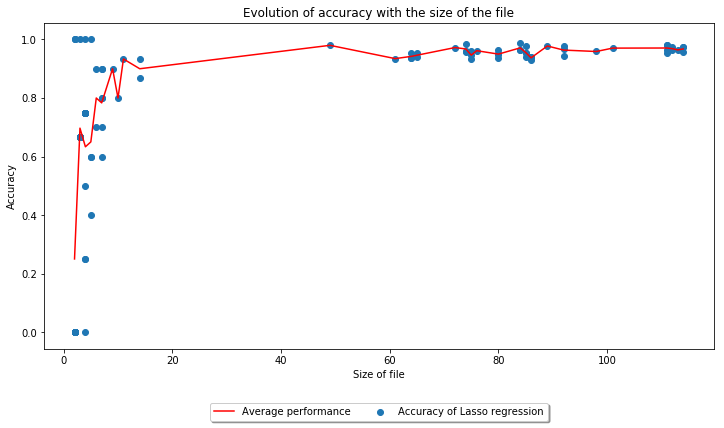

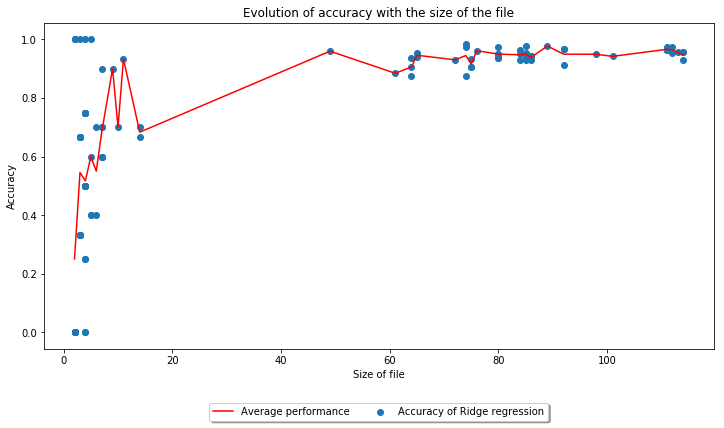

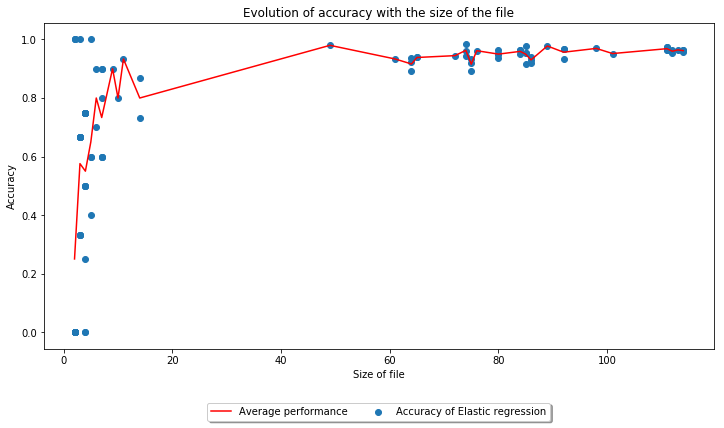

In [140]:
plot_regressor_accuracy('Lasso',x_axis,acc_lasso,d_lasso_list)
plot_regressor_accuracy('Ridge',x_axis,acc_ridge,d_ridge_list)
plot_regressor_accuracy('Elastic',x_axis,acc_ela,d_ela_list)

# Let's compare how our regressors perform on average on charged vs non charged words

In [159]:
print(np.array(acc_lasso).mean())
print(np.array(acc_ridge).mean())
print(np.array(acc_ela).mean())

0.7682830427819192
0.7098933998151907
0.7339516255826968


In [160]:
print(np.array(acc_lasso_charged).mean())
print(np.array(acc_ridge_charged).mean())
print(np.array(acc_ela_charged).mean())

0.8329116074062597
0.7830913198506781
0.798764269895286


However, we now that the small files do not really reflect the accuracy of our regressors, given how the accuracy oscillates in that area, so we would need to compare the 'asymptotic' accuracy for charged and non charged words

In [162]:
print(np.array(acc_lasso[:-20]).mean()) #the small files are appended last to the list, cf. code above
print(np.array(acc_ridge[:-20]).mean())
print(np.array(acc_ela[:-20]).mean())

0.8509866747445333
0.7905255149958964
0.8205240434220458


In [163]:
print(np.array(acc_lasso_charged[:-20]).mean())
print(np.array(acc_ridge_charged[:-20]).mean())
print(np.array(acc_ela_charged[:-20]).mean())

0.9105956683113547
0.8645190205582362
0.879971144686831


In [164]:
print(np.array(acc_lasso[:-40]).mean()) #the small files are appended last to the list, cf. code above
print(np.array(acc_ridge[:-40]).mean())
print(np.array(acc_ela[:-40]).mean())

0.9152446008902817
0.874577596415316
0.9007505057462138


In [165]:
print(np.array(acc_lasso_charged[:-40]).mean())
print(np.array(acc_ridge_charged[:-40]).mean())
print(np.array(acc_ela_charged[:-40]).mean())

0.949813478305075
0.935810169289161
0.9437724241211636


In [168]:
print(np.array(acc_lasso[:-80]).mean()) #the small files are appended last to the list, cf. code above
print(np.array(acc_ridge[:-80]).mean())
print(np.array(acc_ela[:-80]).mean())

0.9621056551506717
0.9533832981682143
0.9576070318102506


In [169]:
print(np.array(acc_lasso_charged[:-80]).mean())
print(np.array(acc_ridge_charged[:-80]).mean())
print(np.array(acc_ela_charged[:-80]).mean())

0.9522619929090518
0.9378509529686
0.9461113657584245


So the results show that asymptotically the performance is similar, however, the ideologically charged words get a faster convergence for the regressors, with smaller datasets and therefore, this confirms that ideologically charged words have more significance and 'betray' the ideology of the speakers.